# Predicting Sale Price from NYC Property Sale Data
## Berkeley SAAS CX Fall 2020 Kaggle Competition
## Ming Fong and Yifan Zhang


## Imports

In [32]:
import numpy as np
import pandas as pd
from sklearn import linear_model
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

In [33]:
# Display all columns of Dataframes
pd.set_option('display.max_columns', None)

## Loading Data

In [34]:
X_train = pd.read_csv("data/train_features.csv")
y_train = pd.read_csv("data/train_targets.csv")
X_test = pd.read_csv("data/test_features.csv")
# sample_submission = pd.read_csv("output/sample_submission.csv")

In [36]:
# merge sale price onto feature data
df = X_train.merge(right = y_train, on = "id", how = "outer")

In [38]:
df = pd.concat([df, X_test], axis=0, ignore_index = True)

In [39]:
df = df.set_index("id")

## Data Preparation

In [40]:
# "EASE-MENT" is an empty column, delete it
del df["EASE-MENT"]

# Delete date column
del df["SALE DATE"]

# These columns are hard to use or repeat information from other columns
del df["LOT"]
del df["ADDRESS"]
del df["APARTMENT NUMBER"]

In [41]:
# Correlation between features

corr = train_merged.corr()
print(corr['SALE PRICE'].sort_values(ascending=False))
sns.heatmap(corr)

In [42]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 37153 entries, train0 to test9288
Data columns (total 19 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   BOROUGH                         37153 non-null  int64  
 1   NEIGHBORHOOD                    37153 non-null  object 
 2   BUILDING CLASS CATEGORY         37153 non-null  object 
 3   TAX CLASS AT PRESENT            37153 non-null  object 
 4   BLOCK                           37153 non-null  int64  
 5   BUILDING CLASS AT PRESENT       37153 non-null  object 
 6   ZIP CODE                        37153 non-null  int64  
 7   RESIDENTIAL UNITS               37153 non-null  int64  
 8   COMMERCIAL UNITS                37153 non-null  int64  
 9   TOTAL UNITS                     37153 non-null  int64  
 10  LAND SQUARE FEET                37153 non-null  float64
 11  GROSS SQUARE FEET               37153 non-null  float64
 12  YEAR BUILT                   

In [43]:
# convert some numeric categoricals to categorical

df['TAX CLASS AT TIME OF SALE'] = df['TAX CLASS AT TIME OF SALE'].astype('category')
df['TAX CLASS AT PRESENT'] = df['TAX CLASS AT PRESENT'].astype('category')
df['LAND SQUARE FEET'] = pd.to_numeric(df['LAND SQUARE FEET'])
df['GROSS SQUARE FEET']= pd.to_numeric(df['GROSS SQUARE FEET'])
df['SALE PRICE'] = pd.to_numeric(df['SALE PRICE'])
df['BOROUGH'] = df['BOROUGH'].astype('category')
df['ZIP CODE'] = df['ZIP CODE'].astype('category')
df['BLOCK'] = df['BLOCK'].astype('category')


In [46]:
df

,BOROUGH,NEIGHBORHOOD,BUILDING CLASS CATEGORY,TAX CLASS AT PRESENT,BLOCK,BUILDING CLASS AT PRESENT,ZIP CODE,RESIDENTIAL UNITS,COMMERCIAL UNITS,TOTAL UNITS,LAND SQUARE FEET,GROSS SQUARE FEET,YEAR BUILT,TAX CLASS AT TIME OF SALE,BUILDING CLASS AT TIME OF SALE,MEDIAN INCOME,MEAN INCOME,POPULATION,SALE PRICE
id,,,,,,,,,,,,,,,,,,,
train0,2,BAYCHESTER,01 ONE FAMILY DWELLINGS,1,4970,A1,10466,1,0,1,2760.0,1056.0,1925,1,A1,48469.7389,57368.0989,68662,315000.0
train1,3,MILL BASIN,01 ONE FAMILY DWELLINGS,1,8621,A1,11234,1,0,1,4317.0,2424.0,1960,1,A1,67952.9473,77076.9976,81033,995000.0
train2,3,MIDWOOD,01 ONE FAMILY DWELLINGS,1,7557,A1,11210,1,0,1,1975.0,1460.0,1915,1,A1,55000.8962,69161.9360,67349,627500.0
train3,3,CLINTON HILL,07 RENTALS - WALKUP APARTMENTS,2A,1965,C4,11238,5,0,5,2200.0,7040.0,1930,2,C4,61468.5107,79249.3305,49085,3200000.0
train4,2,WILLIAMSBRIDGE,02 TWO FAMILY DWELLINGS,1,4866,B1,10466,2,0,2,2136.0,1272.0,1935,1,B1,48469.7389,57368.0989,68662,440000.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
test9284,1,WASHINGTON HEIGHTS LOWER,07 RENTALS - WALKUP APARTMENTS,2,2117,C4,10032,20,0,20,2498.0,9685.0,1913,2,C4,29535.9721,40902.4289,54744,NaN
test9285,5,RICHMONDTOWN-LIGHTHS HILL,01 ONE FAMILY DWELLINGS,1,2287,A3,10306,1,0,1,10600.0,2688.0,1970,1,A3,75212.0632,91445.7035,54812,NaN
test9286,4,CORONA,03 THREE FAMILY DWELLINGS,1,1940,C0,11368,3,0,3,2000.0,3162.0,1969,1,C0,43962.6552,54259.4037,95662,NaN


In [49]:
# Set zero values to mean of non zero values
df["YEAR BUILT"].replace(0, df[df["YEAR BUILT"] != 0]["YEAR BUILT"].mean(), inplace = True)
df["GROSS SQUARE FEET"].replace(0, df[df["GROSS SQUARE FEET"] != 0]["GROSS SQUARE FEET"].mean(), inplace = True)
df["LAND SQUARE FEET"].replace(0, df[df["LAND SQUARE FEET"] != 0]["LAND SQUARE FEET"].mean(), inplace = True)
df["TOTAL UNITS"].replace(0, df[df["TOTAL UNITS"] != 0]["TOTAL UNITS"].mean(), inplace = True)

In [48]:
# select variables for one-hot encoding
categorical_features = ["BOROUGH", "BUILDING CLASS CATEGORY", "TAX CLASS AT TIME OF SALE", "ZIP CODE"]

del df["BUILDING CLASS AT PRESENT"]
del df["TAX CLASS AT PRESENT"]
del df["BUILDING CLASS AT TIME OF SALE"]

# Too many features for location
del df["BLOCK"]
del df["NEIGHBORHOOD"]
# del df["ZIP CODE"]

In [50]:
# One-hot encoding
df = pd.get_dummies(df, columns = categorical_features)
df.info(verbose = True, memory_usage = True, null_counts = True)

<class 'pandas.core.frame.DataFrame'>
Index: 37153 entries, train0 to test9288
Data columns (total 238 columns):
 #   Column                                                                Non-Null Count  Dtype  
---  ------                                                                --------------  -----  
 0   RESIDENTIAL UNITS                                                     37153 non-null  int64  
 1   COMMERCIAL UNITS                                                      37153 non-null  int64  
 2   TOTAL UNITS                                                           37153 non-null  float64
 3   LAND SQUARE FEET                                                      37153 non-null  float64
 4   GROSS SQUARE FEET                                                     37153 non-null  float64
 5   YEAR BUILT                                                            37153 non-null  float64
 6   MEDIAN INCOME                                                         37153 non-null  floa

# Regression

In [52]:
# Get the number of rows from the test data (should be 9289)

test_row_count = X_test.shape[0]
test_row_count

9289

In [53]:
# Split train and test data
from sklearn.model_selection import train_test_split

y = df["SALE PRICE"][:(df.shape[0] - test_row_count)]
X = df[:(df.shape[0] - test_row_count)].drop("SALE PRICE", 1)
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42)

In [54]:
# Standard scaler
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(X_train)
X_train_scaled = pd.DataFrame(scaler.transform(X_train), columns = X_train.columns)
X_valid_scaled = pd.DataFrame(scaler.transform(X_valid), columns = X_valid.columns)

# Scale test data
X_test_new = df[(df.shape[0] - test_row_count):].drop("SALE PRICE", 1)
X_test_scaled = scaler.transform(X_test_new)

In [55]:
from sklearn.metrics import mean_squared_error
# Root mean squared error
def rmse(y_test,y_pred):
      return np.sqrt(mean_squared_error(y_test,y_pred))

In [56]:
X_train_scaled

,RESIDENTIAL UNITS,COMMERCIAL UNITS,TOTAL UNITS,LAND SQUARE FEET,GROSS SQUARE FEET,YEAR BUILT,MEDIAN INCOME,MEAN INCOME,POPULATION,BOROUGH_1,BOROUGH_2,BOROUGH_3,BOROUGH_4,BOROUGH_5,BUILDING CLASS CATEGORY_01 ONE FAMILY DWELLINGS,BUILDING CLASS CATEGORY_02 TWO FAMILY DWELLINGS,BUILDING CLASS CATEGORY_03 THREE FAMILY DWELLINGS,BUILDING CLASS CATEGORY_04 TAX CLASS 1 CONDOS,BUILDING CLASS CATEGORY_05 TAX CLASS 1 VACANT LAND,BUILDING CLASS CATEGORY_06 TAX CLASS 1 - OTHER,BUILDING CLASS CATEGORY_07 RENTALS - WALKUP APARTMENTS,BUILDING CLASS CATEGORY_08 RENTALS - ELEVATOR APARTMENTS,BUILDING CLASS CATEGORY_09 COOPS - WALKUP APARTMENTS,BUILDING CLASS CATEGORY_10 COOPS - ELEVATOR APARTMENTS,BUILDING CLASS CATEGORY_11 SPECIAL CONDO BILLING LOTS,BUILDING CLASS CATEGORY_11A CONDO-RENTALS,BUILDING CLASS CATEGORY_12 CONDOS - WALKUP APARTMENTS,BUILDING CLASS CATEGORY_13 CONDOS - ELEVATOR APARTMENTS,BUILDING CLASS CATEGORY_14 RENTALS - 4-10 UNIT,BUILDING CLASS CATEGORY_15 CONDOS - 2-10 UNIT RESIDENTIAL,BUILDING CLASS CATEGORY_16 CONDOS - 2-10 UNIT WITH COMMERCIAL UNIT,BUILDING CLASS CATEGORY_17 CONDO COOPS,BUILDING CLASS CATEGORY_21 OFFICE BUILDINGS,BUILDING CLASS CATEGORY_22 STORE BUILDINGS,BUILDING CLASS CATEGORY_23 LOFT BUILDINGS,BUILDING CLASS CATEGORY_25 LUXURY HOTELS,BUILDING CLASS CATEGORY_26 OTHER HOTELS,BUILDING CLASS CATEGORY_27 FACTORIES,BUILDING CLASS CATEGORY_28 COMMERCIAL CONDOS,BUILDING CLASS CATEGORY_29 COMMERCIAL GARAGES,BUILDING CLASS CATEGORY_30 WAREHOUSES,BUILDING CLASS CATEGORY_31 COMMERCIAL VACANT LAND,BUILDING CLASS CATEGORY_32 HOSPITAL AND HEALTH FACILITIES,BUILDING CLASS CATEGORY_33 EDUCATIONAL FACILITIES,BUILDING CLASS CATEGORY_34 THEATRES,BUILDING CLASS CATEGORY_35 INDOOR PUBLIC AND CULTURAL FACILITIES,BUILDING CLASS CATEGORY_36 OUTDOOR RECREATIONAL FACILITIES,BUILDING CLASS CATEGORY_37 RELIGIOUS FACILITIES,BUILDING CLASS CATEGORY_38 ASYLUMS AND HOMES,BUILDING CLASS CATEGORY_40 SELECTED GOVERNMENTAL FACILITIES,BUILDING CLASS CATEGORY_41 TAX CLASS 4 - OTHER,BUILDING CLASS CATEGORY_42 CONDO CULTURAL/MEDICAL/EDUCATIONAL/ETC,BUILDING CLASS CATEGORY_43 CONDO OFFICE BUILDINGS,BUILDING CLASS CATEGORY_44 CONDO PARKING,BUILDING CLASS CATEGORY_45 CONDO HOTELS,BUILDING CLASS CATEGORY_46 CONDO STORE BUILDINGS,BUILDING CLASS CATEGORY_47 CONDO NON-BUSINESS STORAGE,BUILDING CLASS CATEGORY_48 CONDO TERRACES/GARDENS/CABANAS,TAX CLASS AT TIME OF SALE_1,TAX CLASS AT TIME OF SALE_2,TAX CLASS AT TIME OF SALE_4,ZIP CODE_10001,ZIP CODE_10002,ZIP CODE_10003,ZIP CODE_10004,ZIP CODE_10005,ZIP CODE_10006,ZIP CODE_10007,ZIP CODE_10009,ZIP CODE_10010,ZIP CODE_10011,ZIP CODE_10012,ZIP CODE_10013,ZIP CODE_10014,ZIP CODE_10016,ZIP CODE_10017,ZIP CODE_10018,ZIP CODE_10019,ZIP CODE_10021,ZIP CODE_10022,ZIP CODE_10023,ZIP CODE_10024,ZIP CODE_10025,ZIP CODE_10026,ZIP CODE_10027,ZIP CODE_10028,ZIP CODE_10029,ZIP CODE_10030,ZIP CODE_10031,ZIP CODE_10032,ZIP CODE_10033,ZIP CODE_10034,ZIP CODE_10035,ZIP CODE_10036,ZIP CODE_10037,ZIP CODE_10038,ZIP CODE_10039,ZIP CODE_10040,ZIP CODE_10044,ZIP CODE_10065,ZIP CODE_10075,ZIP CODE_10128,ZIP CODE_10301,ZIP CODE_10302,ZIP CODE_10303,ZIP CODE_10304,ZIP CODE_10305,ZIP CODE_10306,ZIP CODE_10307,ZIP CODE_10308,ZIP CODE_10309,ZIP CODE_10310,ZIP CODE_10312,ZIP CODE_10314,ZIP CODE_10451,ZIP CODE_10452,ZIP CODE_10453,ZIP CODE_10454,ZIP CODE_10455,ZIP CODE_10456,ZIP CODE_10457,ZIP CODE_10458,ZIP CODE_10459,ZIP CODE_10460,ZIP CODE_10461,ZIP CODE_10462,ZIP CODE_10463,ZIP CODE_10464,ZIP CODE_10465,ZIP CODE_10466,ZIP CODE_10467,ZIP CODE_10468,ZIP CODE_10469,ZIP CODE_10470,ZIP CODE_10471,ZIP CODE_10472,ZIP CODE_10473,ZIP CODE_10474,ZIP CODE_10475,ZIP CODE_10803,ZIP CODE_11001,ZIP CODE_11004,ZIP CODE_11005,ZIP CODE_11040,ZIP CODE_11101,ZIP CODE_11102,ZIP CODE_11103,ZIP CODE_11104,ZIP CODE_11105,ZIP CODE_11106,ZIP CODE_11201,ZIP CODE_11203,ZIP CODE_11204,ZIP CODE_11205,ZIP CODE_11206,ZIP CODE_11207,ZIP CODE_11208,ZIP CODE_11209,ZIP CODE_11210,ZIP CODE_11211,ZIP CODE_11212,ZIP CODE_11213,ZIP CODE_11214,ZIP CODE_11215,ZIP CODE_11

## Linear Regression

In [48]:
# linear regression
linreg = linear_model.LinearRegression()
linreg.fit(X_train_scaled, y_train)
y_pred_lin = linreg.predict(X_valid_scaled)
rmse(y_valid, y_pred_lin)
print("RMSE: " + str(rmse(y_valid, y_pred_lin)))
print('R-squared score (training): {:.3f}'.format(linreg.score(X_train_scaled, y_train)))
print('R-squared score (test): {:.3f}'.format(linreg.score(X_valid_scaled, y_valid)))

RMSE: 7871062.818733652
R-squared score (training): 0.543
R-squared score (test): 0.392


In [49]:
# # Train for final output with both train and valid sets
# linreg.fit(pd.concat([X_train_scaled, X_valid_scaled], axis = 0), pd.concat([y_train, y_valid], axis = 0))
# print('R-squared score (training): {:.3f}'.format(linreg.score(pd.concat([X_train_scaled, X_valid_scaled], axis = 0), pd.concat([y_train, y_valid], axis = 0))))

In [50]:
linear_submission = pd.DataFrame(linreg.predict(X_test_scaled))
linear_submission.index = X_test["id"]
linear_submission.columns = ["SALE PRICE"]
linear_submission.to_csv("output/linear_submission.csv")
linear_submission.head()

,SALE PRICE
id,
test0,1.356331e+07
test1,8.657089e+05
test2,4.888769e+05
test3,1.160621e+06
test4,2.487725e+06


## LASSO Regression

In [20]:
from scipy.optimize import minimize 

In [21]:
# Lasso regression
def lasso(alpha, iterations = 50):
    lasso_regr = linear_model.Lasso(alpha = alpha, max_iter = iterations)
    lasso_regr.fit(X_train, y_train)
    Y_pred_lasso = lasso_regr.predict(X_valid)
    # return rmse(y_valid,Y_pred_lasso)     # this will overfit
    return lasso_regr.score(X_train, y_train) + lasso_regr.score(X_valid, y_valid)

In [22]:
# lasso_res = minimize(lasso, x0 = 10)
# lasso_res

      fun: 0.4689144026425388
 hess_inv: array([[1]])
      jac: array([-2.5331974e-07])
  message: 'Optimization terminated successfully.'
     nfev: 51
      nit: 1
     njev: 17
   status: 0
  success: True
        x: array([31593.99999265])

In [59]:
lasso_regr = linear_model.Lasso(alpha = 0.00099, max_iter = 5000)
lasso_regr.fit(X_train_scaled, y_train)
Y_pred_lasso = lasso_regr.predict(X_valid_scaled)
print("RMSE: " + str(rmse(y_valid, Y_pred_lasso)))
print('R-squared score (training): {:.3f}'.format(lasso_regr.score(X_train_scaled, y_train)))
print('R-squared score (test): {:.3f}'.format(lasso_regr.score(X_valid_scaled, y_valid)))

RMSE: 7957316.709942989
R-squared score (training): 0.544
R-squared score (test): 0.379


In [60]:
# Train for final output with both train and valid sets
lasso_regr.fit(pd.concat([X_train_scaled, X_valid_scaled], axis = 0), pd.concat([y_train, y_valid], axis = 0))
print('R-squared score (training): {:.3f}'.format(lasso_regr.score(pd.concat([X_train_scaled, X_valid_scaled], axis = 0), pd.concat([y_train, y_valid], axis = 0))))

R-squared score (training): 0.539


In [61]:
lasso_submission = pd.DataFrame(lasso_regr.predict(X_test_scaled))
lasso_submission.index = X_test["id"]
lasso_submission.columns = ["SALE PRICE"]
lasso_submission[lasso_submission["SALE PRICE"] < 1000] = y_train.median()       # hard code set < 1000 to median
lasso_submission.to_csv("output/lasso_submission.csv")
lasso_submission.head()

,SALE PRICE
id,
test0,1.389146e+07
test1,8.039087e+05
test2,4.505552e+05
test3,1.249204e+06
test4,2.620162e+06


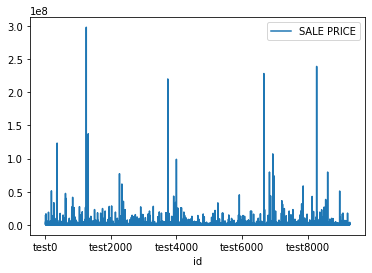

In [62]:
lasso_submission.plot()

## Ridge Regression

In [59]:
# Ridge regression
ridge = linear_model.Ridge(alpha = 0.029, normalize = True)
ridge.fit(X_train_scaled, y_train)
Y_pred_ridge = ridge.predict(X_valid_scaled)
print("RMSE: " + str(rmse(y_valid, Y_pred_ridge)))
print('R-squared score (training): {:.3f}'.format(ridge.score(X_train_scaled, y_train)))
print('R-squared score (test): {:.3f}'.format(ridge.score(X_valid_scaled, y_valid)))

RMSE: 7990095.857629234
R-squared score (training): 0.537
R-squared score (test): 0.374


In [56]:
ridge_submission = pd.DataFrame(ridge.predict(X_test_scaled))
ridge_submission.index = X_test["id"]
ridge_submission.columns = ["SALE PRICE"]
ridge_submission.to_csv("output/ridge_submission.csv")
ridge_submission.head()

,SALE PRICE
id,
test0,1.396353e+07
test1,6.846967e+05
test2,4.095589e+05
test3,1.877738e+06
test4,2.753596e+06


## Random Forest

In [61]:
from sklearn.ensemble import RandomForestRegressor

In [62]:
# Random forest
rf_regr = RandomForestRegressor()
rf_regr.fit(X_train_scaled, y_train)
Y_pred_rf = rf_regr.predict(X_valid_scaled)
rmse(y_valid, Y_pred_rf)
print("RMSE: " + str(rmse(y_valid, Y_pred_rf)))
print('R-squared score (training): {:.3f}'.format(rf_regr.score(X_train_scaled, y_train)))
print('R-squared score (test): {:.3f}'.format(rf_regr.score(X_valid_scaled, y_valid)))

RMSE: 8532998.670698052
R-squared score (training): 0.866
R-squared score (test): 0.285


In [29]:
rf_submission = pd.DataFrame(rf_regr.predict(X_test_scaled))
rf_submission.index = X_test["id"]
rf_submission.columns = ["SALE PRICE"]
rf_submission.to_csv("output/rf_submission.csv")
rf_submission.head()

,SALE PRICE
id,
test0,8.555734e+06
test1,6.210395e+05
test2,5.396837e+05
test3,1.175117e+06
test4,8.957772e+05


## XGBoost

Helpful:

https://www.kaggle.com/darkknight98/how-a-data-scientist-buys-a-house-a-tutorial

In [29]:
import xgboost
from sklearn.model_selection import RandomizedSearchCV

In [31]:
# regressor = xgboost.XGBRegressor()
# n_estimators = [100, 500, 900, 1100, 1500]
# max_depth = [2, 3, 5, 10, 15]
# booster = ['gbtree','gblinear']
# learning_rate = [0.05, 0.1, 0.15, 0.20]
# min_child_weight = [1, 2, 3, 4]
# base_score = [0.25, 0.5, 0.75, 1]

# # Define the grid of hyperparameters to search
# hyperparameter_grid = {
#     'n_estimators': n_estimators,
#     'max_depth': max_depth,
#     'learning_rate': learning_rate,
#     'min_child_weight': min_child_weight,
#     'booster': booster,
#     'base_score': base_score
#     }
# random_cv = RandomizedSearchCV(estimator=regressor,
#             param_distributions=hyperparameter_grid,
#             cv=5, n_iter=50,
#             scoring = 'neg_mean_absolute_error',n_jobs = -1,
#             verbose = 5, 
#             return_train_score = True,
#             random_state=42)

In [32]:
# random_cv.fit(X_train, y_train)

In [33]:
# random_cv.best_estimator_

In [57]:
# TODO tweak these params to find the best one (see code above)

# overfitting documentation: https://xgboost.readthedocs.io/en/latest/tutorials/param_tuning.html
# parameter documentation: https://xgboost.readthedocs.io/en/latest/parameter.html
regressor = xgboost.XGBRegressor(base_score=1, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.1, max_delta_step=0, max_depth=3,
             min_child_weight=1, monotone_constraints='()',
             n_estimators=900, n_jobs=0, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [58]:
regressor.fit(X_train_scaled, y_train)
Y_pred_xgb = regressor.predict(X_valid_scaled)

print("RMSE: " + str(rmse(y_valid, Y_pred_xgb)))
print('R-squared score (training): {:.3f}'.format(regressor.score(X_train_scaled, y_train)))
# regressor.fit(X_valid, y_valid)
print('R-squared score (test): {:.3f}'.format(regressor.score(X_valid_scaled, y_valid)))

RMSE: 8286856.714114094
R-squared score (training): 0.987
R-squared score (test): 0.326


In [59]:
xgb_pred = regressor.predict(X_test_scaled)
xgb_pred = pd.DataFrame(xgb_pred)

xgb_pred.index = X_test["id"]
xgb_pred.columns = ["SALE PRICE"]
xgb_pred[xgb_pred["SALE PRICE"] < 0] = y_train.median()       # hard code set < 0 to median
xgb_pred.to_csv("output/xgb_submission.csv")
xgb_pred.head()

,SALE PRICE
id,
test0,1.327464e+07
test1,9.248446e+05
test2,4.692930e+05
test3,1.218666e+06
test4,1.816803e+06


## Another XGB

In [32]:
dtrain = xgboost.DMatrix(X_train_scaled, label=y_train)
dval = xgboost.DMatrix(X_valid_scaled, label=y_valid)
dtest = xgboost.DMatrix(X_test_scaled)

In [33]:
params = {'learning_rate': 0.001, 'max_depth': 6, 'lambda': 0.01}

model = xgboost.train(params, dtrain, num_boost_round=10000, evals=[(dval, 'eval')], early_stopping_rounds=10)

[0]	eval-rmse:10189322.00000
Will train until eval-rmse hasn't improved in 10 rounds.
[1]	eval-rmse:10186736.00000
[2]	eval-rmse:10184149.00000
[3]	eval-rmse:10181569.00000
[4]	eval-rmse:10178993.00000
[5]	eval-rmse:10176424.00000
[6]	eval-rmse:10173856.00000
[7]	eval-rmse:10171293.00000
[8]	eval-rmse:10168735.00000
[9]	eval-rmse:10166185.00000
[10]	eval-rmse:10163637.00000
[11]	eval-rmse:10161089.00000
[12]	eval-rmse:10158552.00000
[13]	eval-rmse:10156008.00000
[14]	eval-rmse:10153479.00000
[15]	eval-rmse:10150943.00000
[16]	eval-rmse:10148419.00000
[17]	eval-rmse:10145895.00000
[18]	eval-rmse:10143382.00000
[19]	eval-rmse:10140864.00000
[20]	eval-rmse:10138363.00000
[21]	eval-rmse:10135853.00000
[22]	eval-rmse:10133358.00000
[23]	eval-rmse:10130859.00000
[24]	eval-rmse:10128374.00000
[25]	eval-rmse:10125883.00000
[26]	eval-rmse:10123408.00000
[27]	eval-rmse:10120925.00000
[28]	eval-rmse:10118456.00000
[29]	eval-rmse:10115984.00000
[30]	eval-rmse:10113524.00000
[31]	eval-rmse:10111057

In [41]:
xgb_pred2 = model.predict(dtest)
xgb_pred2 = pd.DataFrame(xgb_pred2)

xgb_pred2.index = X_test["id"]
xgb_pred2.columns = ["SALE PRICE"]
# xgb_pred2[xgb_pred2["SALE PRICE"] < 0] = y_train.median()       # hard code set < 0 to median
xgb_pred2.to_csv("output/xgb2_submission.csv")
xgb_pred2.head()

,SALE PRICE
id,
test0,8.511392e+06
test1,6.473911e+05
test2,5.591363e+05
test3,9.237389e+05
test4,1.243197e+06


## Neural Network

In [57]:
from keras.layers import Dense, Activation
from keras.models import Sequential

In [58]:
%%time
# Initialising the ANN
model = Sequential()

# Adding the input layer and the first hidden layer
model.add(Dense(32, activation = 'relu', input_dim = 237))

# Adding the second hidden layer
model.add(Dense(units = 32, activation = 'relu'))

# Adding the third hidden layer
model.add(Dense(units = 32, activation = 'relu'))

# Adding the output layer

model.add(Dense(units = 1))

#model.add(Dense(1))
# Compiling the ANN
model.compile(optimizer = 'adam', loss = 'mean_squared_error')

# Fitting the ANN to the Training set
history = model.fit(X_train_scaled, y_train, batch_size = 100, epochs = 800)

Epoch 1/800
223/223 [==============================] - 0s 2ms/step - loss: 95116572229632.0000
Epoch 2/800
223/223 [==============================] - 0s 1ms/step - loss: 95091297353728.0000
Epoch 3/800
223/223 [==============================] - 0s 1ms/step - loss: 94886011338752.0000
Epoch 4/800
223/223 [==============================] - 0s 1ms/step - loss: 94277359108096.0000
Epoch 5/800
223/223 [==============================] - 0s 1ms/step - loss: 93201637572608.0000
Epoch 6/800
223/223 [==============================] - 0s 1ms/step - loss: 91861423226880.0000
Epoch 7/800
223/223 [==============================] - 0s 1ms/step - loss: 90548505411584.0000
Epoch 8/800
223/223 [==============================] - 0s 1ms/step - loss: 89399375167488.0000
Epoch 9/800
223/223 [==============================] - 0s 1ms/step - loss: 88452016111616.0000
Epoch 10/800
223/223 [==============================] - 0s 1ms/step - loss: 87650937602048.0000
Epoch 11/800
223/223 [===========================

In [59]:
%%time
nn_y_pred = model.predict(X_valid_scaled)

print("RMSE: " + str(rmse(y_valid, nn_y_pred)))

# plt.plot(y_valid, color = 'red', label = 'Real data')
# plt.plot(nn_y_pred, color = 'blue', label = 'Predicted data')
# plt.title('Prediction')
# plt.legend()
# plt.show()

RMSE: 5702421.003629562
Wall time: 428 ms


### RMSEs for validation
500 epochs RMSE: 6102091.199605403

800 epochs RMSE: 5702421.003629562  <- Best Private and Public leaderboard score (late submission)

1000 epochs RMSE: 5157427.023447699 <- Final submission

110 epochs RMSE: 5083102.965332624

1200 epochs RMSE: 4669115.665365743

1400 epochs RMSE: 4398571.978872207

In [ ]:
plt.plot(history.history['loss'])
plt.title("MSE Loss per Iteration")

In [60]:
nn_submission = pd.DataFrame(model.predict(X_test_scaled))
nn_submission.index = X_test["id"]
nn_submission.columns = ["SALE PRICE"]
# nn_submission[xgb_pred["SALE PRICE"] < 0] = y_train.median()       # hard code set < 0 to median
nn_submission.to_csv("output/nn_submission800.csv")
nn_submission.head()

,SALE PRICE
id,
test0,2.572925e+07
test1,6.434898e+05
test2,5.217397e+05
test3,1.145729e+06
test4,1.335121e+06


# Submit to Kaggle
Run this command to submit directly to Kaggle through the Kaggle CLI

In [61]:
!kaggle competitions submit -c saas-2020-fall-cx-kaggle-compeition -f output/nn_submission800.csv -m "epochs=800"

Successfully submitted to SAAS 2020 Fall CX Kaggle Compeition

  0%|          | 0.00/178k [00:00<?, ?B/s]
  5%|▍         | 8.00k/178k [00:00<00:02, 76.6kB/s]
 50%|████▉     | 88.0k/178k [00:00<00:00, 105kB/s] 
 63%|██████▎   | 112k/178k [00:00<00:00, 99.9kB/s]
 77%|███████▋  | 136k/178k [00:00<00:00, 98.5kB/s]
 90%|█████████ | 160k/178k [00:01<00:00, 97.4kB/s]
 99%|█████████▉| 176k/178k [00:01<00:00, 95.6kB/s]
100%|██████████| 178k/178k [00:03<00:00, 58.4kB/s]
